### Environment Setup
This section installs all the necessary dependencies required for the notebook. These libraries include tools for natural language processing, dataset management, and statistical analysis. If you already have a compatible environment, you can skip this step.

In [1]:
# Install dependencies (same as the env file, so you may wish to skip this if running locally / with persistent conda environment)
%pip install transformers
%pip install accelerate
%pip install bitsandbytes
%pip install pyDOE3
%pip install datasets
%pip install torch
%pip install jinja2
%pip install torchmetrics
%pip install tqdm
%pip install jupyter
%pip install pretty-jupyter
%pip install researchpy
%pip install statsmodels
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Library Imports
Here, we import the essential Python libraries and modules that will be used throughout the notebook. These include:
- `transformers` and `datasets` for natural language processing tasks.
- `pyDOE3` for design of experiments.
- `torchmetrics` for evaluation metrics.
- `jinja2` for templating.
- `statsmodels` for statistical modeling.

In [ ]:
import pandas as pd
import csv
import tqdm
import time
import os
import jinja2
import textwrap
import datasets

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from pyDOE3 import *
from torchmetrics.text.rouge import ROUGEScore

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt


### ROUGE Scores and Their Relevance

#### **ROUGE-1**
- **Definition**: Measures the overlap of unigrams (single words) between the candidate (rewritten) text and the reference (original) text.
- **Relevance**: 
  - High **recall** ensures that all key words from the original text are retained in the rewritten version.
  - High **precision** indicates that the rewritten text avoids including unnecessary words not present in the original.
  - **F-Measure** balances precision and recall to provide an overall alignment score.

---

#### **ROUGE-2**
- **Definition**: Measures the overlap of bigrams (two consecutive words) between the candidate and reference text.
- **Relevance**:
  - High **recall** ensures the rewritten text preserves phrasing and contextual meaning from the original.
  - High **precision** confirms that the word pairings are concise and relevant to the original.
  - **F-Measure** assesses the overall similarity in phrasing and flow between the texts.

---

#### **ROUGE-L**
- **Definition**: Evaluates the longest common subsequence (LCS) between the candidate and reference text.
- **Relevance**:
  - High **recall** indicates the rewritten text maintains the sequence and structure of the original.
  - High **precision** ensures that the sequence includes no extraneous content.
  - **F-Measure** provides a balanced metric for assessing structural and sequential fidelity.

---

#### **ROUGE-Lsum**
- **Definition**: Extends ROUGE-L to multi-sentence or paragraph-level comparisons by analyzing the longest common subsequence across text segments.
- **Relevance**:
  - Ensures that the overall structure, coherence, and flow of the rewritten text are consistent with the original at a broader level.
  - Useful for tasks involving longer passages or summaries.

---

These scores collectively evaluate how well the rewritten text adheres to the original, balancing precision (conciseness) and recall (completeness) to ensure the meaning is preserved without unnecessary additions.

/var/folders/hm/5m8v39gs5yj35nkyd_qbnpzm0000gn/T/ipykernel_35456/446722989.py:6: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("./output.csv", delimiter='§')


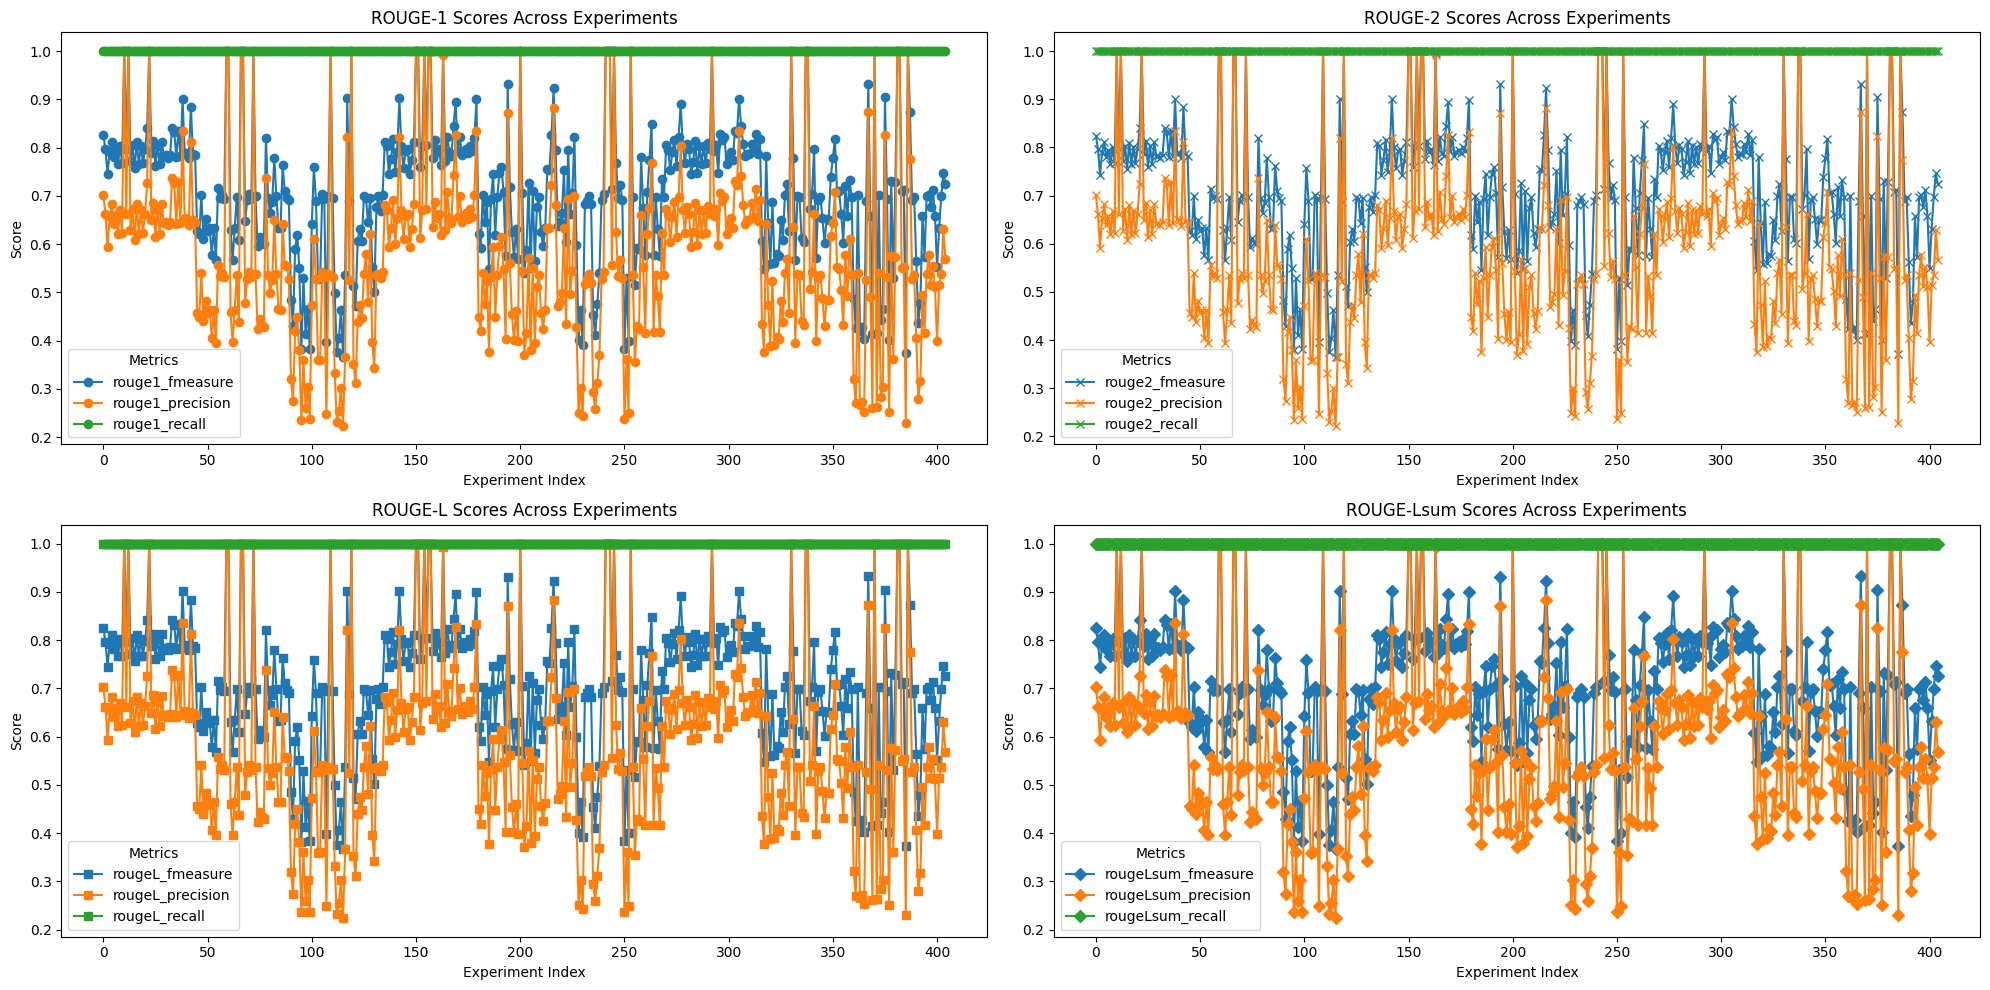

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re  # Import regular expression module

# Read the CSV file containing the outputs
df = pd.read_csv("./output.csv", delimiter='§')

# Function to safely extract numeric value from a tensor string like 'tensor(0.8250)'
def extract_tensor_value(value):
    """ Extracts the float value from a tensor string like 'tensor(0.8250)' """
    if isinstance(value, str):
        # Replace 'tensor(' and ')' to extract the numeric value
        tensor_match = re.match(r"tensor\(([^)]+)\)", value)
        if tensor_match:
            return float(tensor_match.group(1))
    return value  # Return the value if it's already numeric

# Function to parse the 'score' column and convert it to a dictionary with float values
def parse_score_column(score_str):
    """ Convert the score string to a dictionary with tensor values extracted """
    # First replace tensor-like patterns with numeric values
    score_str = re.sub(r"tensor\(([^)]+)\)", r"\1", score_str)  # Replace 'tensor(x)' with 'x'
    
    # Safely evaluate the dictionary string
    score_dict = eval(score_str)  # This converts the cleaned-up string to a dictionary

    # Convert all values in the dictionary to float if they are tensor-like strings
    for key, value in score_dict.items():
        score_dict[key] = extract_tensor_value(value)
    
    return score_dict

# Apply the function to the 'score' column to convert to dictionaries with float values
df['score'] = df['score'].apply(parse_score_column)

# Now, extract the individual ROUGE metrics and convert them into separate columns
df['rouge1_fmeasure'] = df['score'].apply(lambda x: x['rouge1_fmeasure'])
df['rouge1_precision'] = df['score'].apply(lambda x: x['rouge1_precision'])
df['rouge1_recall'] = df['score'].apply(lambda x: x['rouge1_recall'])
df['rouge2_fmeasure'] = df['score'].apply(lambda x: x['rouge2_fmeasure'])
df['rouge2_precision'] = df['score'].apply(lambda x: x['rouge2_precision'])
df['rouge2_recall'] = df['score'].apply(lambda x: x['rouge2_recall'])
df['rougeL_fmeasure'] = df['score'].apply(lambda x: x['rougeL_fmeasure'])
df['rougeL_precision'] = df['score'].apply(lambda x: x['rougeL_precision'])
df['rougeL_recall'] = df['score'].apply(lambda x: x['rougeL_recall'])
df['rougeLsum_fmeasure'] = df['score'].apply(lambda x: x['rougeLsum_fmeasure'])
df['rougeLsum_precision'] = df['score'].apply(lambda x: x['rougeLsum_precision'])
df['rougeLsum_recall'] = df['score'].apply(lambda x: x['rougeLsum_recall'])

# Plotting with pandas' built-in plotting capabilities
plt.figure(figsize=(20, 10))

# ROUGE-1
plt.subplot(2, 2, 1)
df[['rouge1_fmeasure', 'rouge1_precision', 'rouge1_recall']].plot(ax=plt.gca(), marker='o')
plt.title("ROUGE-1 Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-2
plt.subplot(2, 2, 2)
df[['rouge2_fmeasure', 'rouge2_precision', 'rouge2_recall']].plot(ax=plt.gca(), marker='x')
plt.title("ROUGE-2 Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-L
plt.subplot(2, 2, 3)
df[['rougeL_fmeasure', 'rougeL_precision', 'rougeL_recall']].plot(ax=plt.gca(), marker='s')
plt.title("ROUGE-L Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-Lsum
plt.subplot(2, 2, 4)
df[['rougeLsum_fmeasure', 'rougeLsum_precision', 'rougeLsum_recall']].plot(ax=plt.gca(), marker='D')
plt.title("ROUGE-Lsum Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# Display the plots
plt.tight_layout()
plt.show()